### Cross Sell Model Retail Clients

Based on bio  and transactional data currently available from the core banking system, the following exploratory analysis has been carried out:

In [1]:
# Initialization cells
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

np.set_printoptions(precision=2, suppress=True)

import warnings
warnings.filterwarnings('ignore')

### Product table as run using the prod_age_rec.sql query (fetch dat from the Enterprise Data Warehouse)
The aim is to create a table that has product age, age of customer and a rating derived from dividing the two. 
This helps in the ranking used in collaborative filtering which is the algorithm used in this case
* cosine_similarity is used (i.e. how similar people are based on length of time products have been held)
* 30 most similar customers are then picked and products preference is ranked from highest to lowest
* Products held are then removed and the highest ranking products remaining, recommended to the customer

In [2]:
# Data from prod_age_rec.sql
# other_table = pd.read_csv('RecData.txt',delimiter='|')
# prod_table = pd.read_csv('RecData.txt',delimiter='|')
prod_table = pd.read_csv('prod_age_chnw_jun22.csv')

In [3]:
prod_table.head()

,CUSTOMER,PROD_GRP,PROD_AGE,AGE,RATING
0,922595,HOME.LOAN,13,49,0.27
1,965501,HOME.LOAN,12,60,0.20
2,958896,HOME.LOAN,12,64,0.19
3,971938,HOME.LOAN,12,59,0.20
4,975993,HOME.LOAN,12,59,0.20


Get the unique products held by the customers in Consumer and High Net Worth business unit

In [4]:
prod_table['PROD_GRP'].unique(), prod_table['PROD_GRP'].nunique()

(array(['HOME.LOAN', 'MOBILE.DIGITAL.LENDING', 'VAF.LOAN', 'BUSINESS.LOAN',
        'IPF', 'FIXED.DEPOSIT', 'CALL.DEPOSIT', 'SAFRCOM.LN',
        'CURRENT.ACCOUNTS', 'SAVINGS.ACCOUNTS', nan], dtype=object), 10)

In [6]:
#Drop the null values on the product column
prod_table.dropna(subset=['PROD_GRP'], inplace=True)
prod_table.head()

,CUSTOMER,PROD_GRP,PROD_AGE,AGE,RATING
0,922595,HOME.LOAN,13,49,0.27
1,965501,HOME.LOAN,12,60,0.20
2,958896,HOME.LOAN,12,64,0.19
3,971938,HOME.LOAN,12,59,0.20
4,975993,HOME.LOAN,12,59,0.20


In [7]:
prod_table.isna().sum()

CUSTOMER    0
PROD_GRP    0
PROD_AGE    0
AGE         0
RATING      0
dtype: int64

Visualize the distribution of product holdings in the segment

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'CURRENT.ACCOUNTS'),
  Text(1, 0, 'SAVINGS.ACCOUNTS'),
  Text(2, 0, 'MOBILE.DIGITAL.LENDING'),
  Text(3, 0, 'VAF.LOAN'),
  Text(4, 0, 'HOME.LOAN'),
  Text(5, 0, 'FIXED.DEPOSIT'),
  Text(6, 0, 'IPF'),
  Text(7, 0, 'CALL.DEPOSIT'),
  Text(8, 0, 'BUSINESS.LOAN'),
  Text(9, 0, 'SAFRCOM.LN')])

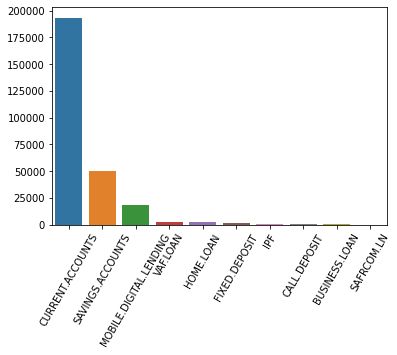

In [8]:
sns.barplot(prod_table['PROD_GRP'].value_counts().index,prod_table['PROD_GRP'].value_counts().values)
plt.xticks(rotation=60)

In [9]:
prod_table['PROD_GRP'].value_counts()

CURRENT.ACCOUNTS          193590
SAVINGS.ACCOUNTS           50346
MOBILE.DIGITAL.LENDING     18625
VAF.LOAN                    2811
HOME.LOAN                   2337
FIXED.DEPOSIT               1129
IPF                          861
CALL.DEPOSIT                 545
BUSINESS.LOAN                142
SAFRCOM.LN                     6
Name: PROD_GRP, dtype: int64

Get the product rating by dividing the number of active years of the product with the age of customer
* This allows for smoothing of the rating based on actual age

In [10]:
# Drop the non eligible products fro CHNW 
prod_table = prod_table[prod_table['PROD_GRP'] != 'BUSINESS.LOAN']
prod_table = prod_table[prod_table['PROD_GRP'] != 'CORPORATE.LOAN']
prod_table = prod_table[prod_table['PROD_GRP'] != 'SAFRCOM.LN']

In [11]:
# Get the product rating by dividing the number of product active years with the age of customer
prod_table['RATING_NM'] = prod_table['RATING'] 

# Map the products with numeric codes to aid with creation of the matrix (note the prod_id column should not have .0, \
# if it does the mapping has not been done correctly)
di = {'HOME.LOAN':1000,'BUSINESS.LOAN': 1001,'VAF.LOAN':1002,'IPF':1003, 'CURRENT.ACCOUNTS':1004, 'SAVINGS.ACCOUNTS':1005, 
      'FIXED.DEPOSIT':1006, 'MOBILE.DIGITAL.LENDING':1007, 'PERSONAL.LN':1008,'CALL.DEPOSIT':10010, 'TRADE':10011, 'SAFRCOM.LN':10012 }  

prod_table['PROD_ID'] = prod_table['PROD_GRP'].map(di)
prod_table.head()          

,CUSTOMER,PROD_GRP,PROD_AGE,AGE,RATING,RATING_NM,PROD_ID
0,922595,HOME.LOAN,13,49,0.27,0.27,1000
1,965501,HOME.LOAN,12,60,0.20,0.20,1000
2,958896,HOME.LOAN,12,64,0.19,0.19,1000
3,971938,HOME.LOAN,12,59,0.20,0.20,1000
4,975993,HOME.LOAN,12,59,0.20,0.20,1000


#### Standardizing the output to cater for difference in product ages
* To take care of difference in customer age and holding, the rating has been standardized by subtracting the mean product holding age
* This allows for comparison of new customers and old existing customers as the average product holding age would be subtracted

In [12]:
Mean = prod_table.groupby(by="CUSTOMER",as_index=False)['RATING_NM'].mean()
Prod_avg = pd.merge(prod_table,Mean,on='CUSTOMER')
Prod_avg['ADG_RATING']=Prod_avg['RATING_NM_x']-Prod_avg['RATING_NM_y']

In [13]:
Prod_avg['PROD_ID'].unique(), Prod_avg.shape

(array([ 1000,  1004,  1005,  1007,  1003, 10010,  1002,  1006],
       dtype=int64), (270244, 9))

In [14]:
Prod_avg.head()

,CUSTOMER,PROD_GRP,PROD_AGE,AGE,RATING,RATING_NM_x,PROD_ID,RATING_NM_y,ADG_RATING
0,922595,HOME.LOAN,13,49,0.27,0.27,1000,0.172,0.098
1,922595,CURRENT.ACCOUNTS,2,49,0.04,0.04,1004,0.172,-0.132
2,922595,SAVINGS.ACCOUNTS,7,49,0.14,0.14,1005,0.172,-0.032
3,922595,MOBILE.DIGITAL.LENDING,1,49,0.02,0.02,1007,0.172,-0.152
4,922595,CURRENT.ACCOUNTS,19,49,0.39,0.39,1004,0.172,0.218


##### Create a table to be used to check existing product holdings of the customer

In [15]:
check = pd.pivot_table(Prod_avg,values='RATING_NM_x',index='CUSTOMER',columns='PROD_ID')
check.head()

PROD_ID,1000,1002,1003,1004,1005,1006,1007,10010
CUSTOMER,,,,,,,,
900008,NaN,NaN,NaN,0.21,0.07,NaN,NaN,NaN
900011,NaN,NaN,NaN,0.96,NaN,NaN,NaN,NaN
900012,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN
900014,NaN,NaN,NaN,0.12,0.02,NaN,0.035,NaN
900029,NaN,NaN,NaN,0.30,NaN,NaN,NaN,NaN


##### Create the final table with standardized ratings

In [16]:
final = pd.pivot_table(Prod_avg,values='ADG_RATING',index='CUSTOMER',columns='PROD_ID')
final.head()

PROD_ID,1000,1002,1003,1004,1005,1006,1007,10010
CUSTOMER,,,,,,,,
900008,NaN,NaN,NaN,0.093333,-0.046667,NaN,NaN,NaN
900011,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
900012,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
900014,NaN,NaN,NaN,0.067500,-0.032500,NaN,-0.0175,NaN
900029,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN


To fill in the Nan values two approaches can be used
* Product average (column-wise)
* Customer average (row-wise)

Customer average is preferred as the user to user collaborative filtering will be used (user centric approach)

In [17]:
# Replacing NaN by Prod Average - product similarity approach
# final_prod = final.fillna(final.mean(axis=0))

# Replacing NaN by user Average to fill in the matrix - user centric approach
final_customer = final.apply(lambda row: row.fillna(row.mean()), axis=1)

In [18]:
# Drop rows that have zero values
final_customer = final_customer.loc[(final_customer !=0).any(axis=1)]

In [19]:
final_customer.shape

(31384, 8)

In [20]:
final_customer = final_customer[~final_customer.index.duplicated(keep='last')]
final_customer.query('CUSTOMER == 1124001')

PROD_ID,1000,1002,1003,1004,1005,1006,1007,10010
CUSTOMER,,,,,,,,
1124001,0.076667,-0.000333,-0.103333,0.126667,0.001667,-0.000333,-0.103333,-0.000333


### Cosine similarity

**Cosine Similarity** measures the similarity between two vectors of an inner product space. It is measured by the cosine of the angle between two vectors and determines whether two vectors are pointing in roughly the same direction. In this case, the similarity based on product holding ratings.

In [21]:
# user similarity on replacing NAN by user avg
b = cosine_similarity(final_customer)
np.fill_diagonal(b, 0 )
similarity_with_customer = pd.DataFrame(b,index=final_customer.index)
similarity_with_customer.columns=final_customer.index
similarity_with_customer.head()

CUSTOMER,900008,900014,900039,900104,900105,900107,900109,900112,900113,900117,900128,900130,900135,900150,900158,900163,900177,900188,900190,900192,900194,900196,900200,900202,900214,900215,900232,900235,900238,900242,900248,900266,900295,900303,900304,900309,900321,900331,900338,900345,900357,900374,900375,900386,900416,900425,900439,900443,900455,900463,900489,900495,900503,900519,900520,900521,900531,900620,900638,900649,900653,900670,900681,900690,900714,900715,900726,900745,900755,900761,900774,900798,900832,900856,900857,900873,900875,900876,900879,900898,900919,900938,900940,900952,900958,900967,901021,901024,901025,901029,901058,901064,901091,901093,901094,901103,901109,901120,901134,901145,901172,901173,901225,901252,901263,901273,901391,901408,901444,901446,901447,901450,901454,901455,901474,901485,901486,901494,901495,901496,901503,901510,901512,901541,901569,901575,901578,901619,901701,901707,901715,901745,901748,901754,901781,901791,901799,901801,901810,901812,901814,901822,901829,901850,901851,901860,901878,901904,901907,901914,901921,901928,901929,901943,901950,901952,901965,901972,901987,901990,901994,901996,901998,902002,902024,902065,902109,902110,902123,902150,902171,902178,902179,902187,902199,902223,902241,902245,902264,902266,902287,902298,902340,902366,902420,902429,902435,902453,902454,902467,902478,902491,902501,902519,902522,902533,902542,902547,902552,902567,902578,902601,902609,902624,902627,902633,902648,902651,902656,902661,902679,902697,902735,902743,902760,902774,902809,902835,902855,902865,902873,902883,905018,905031,905048,905084,905092,905100,905103,905108,905123,905137,905144,905167,905180,905182,905189,905215,905216,905222,905243,905272,905282,905331,905349,905364,905369,905444,905495,905500,...,1426534,1426547,1426552,1426554,1426582,1426591,1426599,1426609,1426613,1426617,1426650,1426689,1426697,1426711,1426775,1426802,1426803,1426805,1426816,1426831,1426846,1426860,1426869,1426871,1426872,1426888,1426910,1426932,1426949,1426958,1426967,1427002,1427013,1427033,1427047,1427055,1427082,1427088,1427125,1427166,1427168,1427183,1427191,1427194,1427201,1427214,1427215,1427271,1427274,1427346,1427350,1427384,1427390,1427422,1427429,1427434,1427435,1427438,1427440,1427469,1427478,1427505,1427512,1427518,1427540,1427563,1427574,1427615,1427621,1427633,1427660,1427672,1427673,1427689,1427720,1427730,1427755,1427775,1427794,1427801,1427807,1427820,1427822,1427880,1427976,1427990,1427992,1427993,1428020,1428021,1428034,1428048,1428055,1428075,1428093,1428099,1428105,1428117,1428123,1428142,1428165,1428169,1428268,1428272,1428329,1428352,1428364,1428372,1428389,1428409,1428432,1428455,1428459,1428465,1428485,1428489,1428496,1428519,1428521,1428529,1428534,1428545,1428556,1428557,1428558,1428561,1428571,1428581,1428606,1428675,1428682,1428684,1428692,1428703,1428718,1428737,1428742,1428743,1428757,1428780,1428806,1428810,1428844,1428848,1428857,1428864,1428880,1428892,1428893,1428894,1428913,1428915,1428923,1428942,1428950,1428995,1429001,1429050,1429055,1429069,1429078,1429134,1429156,1429166,1429167,1429193,1429197,1429237,1429249,1429262,1429272,1429287,1429322,1429364,1429399,1429444,1429446,1429455,1429465,1429482,1429485,1429494,1429497,1429510,1429525,1429531,1429552,1429556,1429575,1429581,1429595,1429597,1429600,1429628,1429635,1429661,1429663,1429669,1429682,1429693,1429701,1429713,1429718,1429729,1429733,1429737,1429773,1429777,1429781,1429782,1429791,1429796,1429842,1429861,1429877,1429896,1429900,1429903,1429904,1429910,1429926,1429942,1429954,1429980,1429994,1429997,1430007,1430018,1430040,1430048,1430083,1430093,1430116,1430117,1430130,1430148,1430153,1430159,1430167,1430175,1430190,1430201,1430215,1430219,1430254,1430255,1430264,1474761,1479683,1531500
CUSTOMER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

### Getting similar users for product recommendation (kNN, k=30)
The kNN algorithm will be used to get the 30 most similar customers. These will then be used to recommend products to the customer

In [22]:
## Function to get similar customers
def find_n_neighbours(df,n):
    order = np.argsort(df.values, axis=1)[:, :n]
    df = df.apply(lambda x: pd.Series(x.sort_values(ascending=False)
           .iloc[:n].index, 
          index=['top{}'.format(i) for i in range(1, n+1)]), axis=1)
    return df

In [24]:
# top 30 neighbours for each user
sim_customer_30_u = find_n_neighbours(similarity_with_customer,30)
sim_customer_30_u.head()

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10,top11,top12,top13,top14,top15,top16,top17,top18,top19,top20,top21,top22,top23,top24,top25,top26,top27,top28,top29,top30
CUSTOMER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
900008,970342,1229883,1138454,1271897,965594,1292092,1391910,1158532,1292000,957242,1070141,986843,1279994,905216,1168181,1202649,1083062,1254072,1146192,1271401,921436,1242717,1123918,1372044,1210403,1079105,1335701,976331,1335898,1145463
900014,1351035,1343967,1286779,1077965,969869,1323590,1135614,1179370,1187955,1174584,1251808,1068548,1027655,1293917,1128816,1131135,1269739,902648,991200,967704,1065252,1279029,1285919,1224165,1177841,1016137,1027677,1221931,1398881,1402880
900039,918852,978143,965847,1102395,1028923,1127784,1338316,1388588,991432,1100290,1173701,959729,1303286,1100583,991061,1171310,1328838,1338261,1303304,1369033,1368858,1286602,1316358,1171676,1369047,1379727,1322099,1303353,1099478,991696
900104,1080898,1137986,980858,1202309,1248674,1267343,1202549,1203025,901455,1266229,1075063,983424,1120429,1073356,1121646,984265,984488,1364875,1225407,980594,1117080,976779,1142712,1226503,1274219,1125625,1141934,976215,1117682,1077442
900105,971593,1059495,1059499,991942,1165462,957150,1048469,958132,912160,1221438,1174432,922501,1159055,1146768,1055812,912037,1055910,964507,1301743,1087452,1301738,1345790,959659,1104452,1113789,1055114,1147299,1079696,912525,1301582


##### Get the customer product score

In [25]:
def Customer_prod_score(cus,item):
    a = sim_customer_30_u[sim_customer_30_u.index==cus].values
    b = a.squeeze().tolist()
    c = final_customer.loc[:,item]
    d = c[c.index.isin(b)]
    f = d[d.notnull()]
    avg_user = Mean.loc[Mean['CUSTOMER'] == cus,'RATING_NM'].values[0]
    index = f.index.values.squeeze().tolist()
    corr = similarity_with_user.loc[cus,index]
    fin = pd.concat([f, corr], axis=1)
    fin.columns = ['adg_score','correlation']
    fin['score']=fin.apply(lambda x:x['adg_score'] * x['correlation'],axis=1)
    nume = fin['score'].sum()
    deno = fin['correlation'].sum()
    final_score = avg_user + (nume/deno)
    return final_score

Create a table of product holding

In [26]:
Prod_avg = Prod_avg.astype({"PROD_ID": str})
Prod_user = Prod_avg.groupby(by = 'CUSTOMER')['PROD_ID'].apply(lambda x:','.join(x))
user = list(map(int,final_customer.index.values.tolist()))

##### Predicting the customer products

In [ ]:
# Get products used by a specific user from the check DataFrame
def get_products_used_by_user(user, check):
    return check.columns[check.loc[user].notna()].tolist()

# Get products used by similar users based on sim_customer_30_u and Prod_user DataFrames
def get_similar_users_products(user, sim_customer_30_u, Prod_user):
    similar_users = sim_customer_30_u.loc[user].squeeze().tolist()
    products_used_by_similar_users = Prod_user[Prod_user.index.isin(similar_users)]
    products_used_by_similar_users = products_used_by_similar_users.values.flatten()
    return products_used_by_similar_users.tolist()

# Calculate recommendation scores for products
def calculate_recommendation_score(user, Prods_under_consideration, final_customer, Mean, similarity_with_customer):
    scores = []
    avg_user = Mean.loc[Mean['CUSTOMER'] == user, 'RATING_NM'].values[0]
    
    for item in Prods_under_consideration:
        user_ratings = final_customer[item]
        similar_users_ratings = user_ratings[user_ratings.index.isin(similar_users)]
        valid_ratings = similar_users_ratings.dropna()
        
        user_corr = similarity_with_customer.loc[user, valid_ratings.index]
        merged_data = pd.concat([valid_ratings, user_corr], axis=1)
        merged_data.columns = ['adg_score', 'correlation']
        
        merged_data['score'] = merged_data.apply(lambda x: x['adg_score'] * x['correlation'], axis=1)
        nume = merged_data['score'].sum()
        deno = merged_data['correlation'].sum()
        final_score = avg_user + (nume / deno)
        scores.append(final_score)
    
    return scores

# Get top recommended product names
def get_top_recommendations(Prods_under_consideration, scores, prod_table):
    data = pd.DataFrame({'PROD_ID': Prods_under_consideration, 'score': scores})
    top_recommendations = data.sort_values(by='score', ascending=False).head(5)
    recommendations_with_names = top_recommendations.merge(prod_table, how='inner', on='PROD_ID')
    recommended_product_names = recommendations_with_names['PROD_GRP'].values.tolist()
    return recommended_product_names

# Main function for calculating user-item scores and generating recommendations
def user_item_score(user, check, sim_customer_30_u, Prod_user, final_customer, Mean, similarity_with_customer, prod_table):
    Prod_used_by_user = get_products_used_by_user(user, check)
    similar_users = sim_customer_30_u.loc[user].squeeze().tolist()
    Prod_used_by_similar_users = get_similar_users_products(user, sim_customer_30_u, Prod_user)
    
    Prods_under_consideration = list(set(Prod_used_by_similar_users) - set(map(str, Prod_used_by_user)))
    Prods_under_consideration = list(map(int, Prods_under_consideration))
    
    scores = calculate_recommendation_score(user, Prods_under_consideration, final_customer, Mean, similarity_with_customer)
    
    recommended_product_names = get_top_recommendations(Prods_under_consideration, scores, prod_table)
    
    return recommended_product_names


#### Function that checks on customers product holding and compares it to similar customer product holdings
* It returns a list of products that are ranked highly per customer but that are not currently held
* Refers to the table named check above

In [ ]:
def Recommender(users_to_predict, check, sim_customer_30_u, Prod_user, final_customer, Mean, similarity_with_customer):
    """
    Generate product recommendations for a list of customers.

    Args:
        users_to_predict (list): List of customer numbers (CIF) to be predicted.
        check (DataFrame): DataFrame containing product usage information.
        sim_customer_30_u (DataFrame): DataFrame containing similarity scores between customers.
        Prod_user (DataFrame): DataFrame containing products used by customers.
        final_customer (DataFrame): DataFrame containing customer-product ratings.
        Mean (DataFrame): DataFrame containing customer average ratings.
        similarity_with_customer (DataFrame): DataFrame containing similarity scores between customers.

    Returns:
        DataFrame: Recommendations containing 'PROD_ID', 'score', and 'CUSTOMER'.
    """
    users_to_predict = list(map(int,users_to_predict))
    customer = []
    prod = []
    score = []

    for user in users_to_predict:
        # Get products used by the user and by similar users
        Prod_used_by_user = check.columns[check.loc[user].notna().any()].tolist()
        similar_users = sim_customer_30_u.loc[user].squeeze().tolist()
        Prod_used_by_similar_users = Prod_user[Prod_user.index.isin(similar_users)]
        Prods_under_consideration = list(set(Prod_used_by_similar_users.values.flatten()) - set(map(str, Prod_used_by_user)))
        Prods_under_consideration = list(map(int, Prods_under_consideration))

        for item in Prods_under_consideration:
            customer.append(user)
            prod.append(item)

            # Calculate recommendation scores for products
            user_ratings = final_customer[item]
            similar_users_ratings = user_ratings[user_ratings.index.isin(similar_users)]
            valid_ratings = similar_users_ratings.dropna()
            user_corr = similarity_with_customer.loc[user, valid_ratings.index]
            merged_data = pd.concat([valid_ratings, user_corr], axis=1)
            merged_data.columns = ['adg_score', 'correlation']

            # Calculate the score as the product of adg_score and correlation
            merged_data['score'] = merged_data.apply(lambda x: x['adg_score'] * x['correlation'], axis=1)
            nume = merged_data['score'].sum()
            deno = merged_data['correlation'].sum()

            # Calculate the final score for the item recommendation
            avg_user = Mean.loc[Mean['CUSTOMER'] == user, 'RATING_NM'].values[0]
            final_score = avg_user + (nume / deno)
            score.append(final_score)

    df = pd.DataFrame({'PROD_ID': prod, 'score': list(np.around(np.array(score), 8)), 'CUSTOMER': customer})
    return df


In [29]:
# Get a list of all customer numbers
customers_pred = final_customer.index.values.tolist()

In [30]:
# Use the recommender function above to return recommended products
data = Recommender(customers_pred, check, sim_customer_30_u, Prod_user, final_customer, Mean, similarity_with_customer)

In [31]:
data.query("CUSTOMER==1124001")

,PROD_ID,score,CUSTOMER
5009,1002,0.122444,1124001


In [32]:
# Mapping of product IDs to product names
product_id_to_name = {
    1000: 'HOME.LOAN', 1001: 'BUSINESS.LOAN', 1002: 'VAF.LOAN', 1003: 'IPF',
    1004: 'CURRENT.ACCOUNTS', 1005: 'SAVINGS.ACCOUNTS', 1006: 'FIXED.DEPOSIT',
    1007: 'MOBILE.DIGITAL.LENDING', 1008: 'PERSONAL.LN', 10010: 'CALL.DEPOSIT',
    10011: 'TRADE', 10012: 'SAFRCOM.LN'
}

# Create a pivot table from the data DataFrame
pivot_table = pd.pivot_table(data, values='score', index='CUSTOMER', columns='PROD_ID')

# Map column indices (product IDs) to product names
pivot_table.columns = pivot_table.columns.map(product_id_to_name)

# Fill NaN values with 0
pivot_table.fillna(0, inplace=True)

# Print the pivot table
print(pivot_table.head())


PROD_ID,HOME.LOAN,VAF.LOAN,IPF,CURRENT.ACCOUNTS,SAVINGS.ACCOUNTS,FIXED.DEPOSIT,MOBILE.DIGITAL.LENDING,CALL.DEPOSIT
CUSTOMER,,,,,,,,
900039,0.275000,0.00000,0.0,0.275000,0.275000,0.0,0.275000,0.0000
900112,0.305000,0.00000,0.0,0.000000,0.305000,0.0,0.305000,0.0000
900117,0.140000,0.00000,0.0,0.000000,0.140000,0.0,0.140000,0.0000
900130,0.223608,0.22233,0.0,0.224487,0.000000,0.0,0.225629,0.2224
900150,0.000000,0.00000,0.0,0.000000,0.153614,0.0,0.153652,0.0000


##### A function that goes through the dataframe and returns the recommended products names (maps the prod_id to prod_name)

In [33]:
def sort_df(df):
    """
    Sort the columns of a DataFrame in descending order and create a new DataFrame with sorted column labels.

    Args:
        df (DataFrame): Input DataFrame to be sorted.

    Returns:
        DataFrame: New DataFrame with sorted column labels.
    """
    sorted_tags = pd.DataFrame(index=df.index, columns=['prod_{}'.format(i) for i in range(df.shape[1])])

    for i in range(df.shape[0]):
        # Sort the values of the current row in descending order and get the corresponding column labels
        sorted_column_labels = df.iloc[i, :].sort_values(ascending=False).index
        sorted_tags.iloc[i, :] = list(sorted_column_labels)

    return sorted_tags

In [34]:
final_pred = sort_df(pivot_table)

In [35]:
final_pred.head()

,prod_0,prod_1,prod_2,prod_3,prod_4,prod_5,prod_6,prod_7
CUSTOMER,,,,,,,,
900039,HOME.LOAN,CURRENT.ACCOUNTS,SAVINGS.ACCOUNTS,MOBILE.DIGITAL.LENDING,VAF.LOAN,IPF,FIXED.DEPOSIT,CALL.DEPOSIT
900112,HOME.LOAN,SAVINGS.ACCOUNTS,MOBILE.DIGITAL.LENDING,VAF.LOAN,IPF,CURRENT.ACCOUNTS,FIXED.DEPOSIT,CALL.DEPOSIT
900117,HOME.LOAN,SAVINGS.ACCOUNTS,MOBILE.DIGITAL.LENDING,VAF.LOAN,IPF,CURRENT.ACCOUNTS,FIXED.DEPOSIT,CALL.DEPOSIT
900130,MOBILE.DIGITAL.LENDING,CURRENT.ACCOUNTS,HOME.LOAN,CALL.DEPOSIT,VAF.LOAN,IPF,SAVINGS.ACCOUNTS,FIXED.DEPOSIT
900150,MOBILE.DIGITAL.LENDING,SAVINGS.ACCOUNTS,HOME.LOAN,VAF.LOAN,IPF,CURRENT.ACCOUNTS,FIXED.DEPOSIT,CALL.DEPOSIT


In [36]:
# Pick the highest ranked products
two_prod = final_pred[['prod_0']]
two_prod.head()

,prod_0
CUSTOMER,
900039,HOME.LOAN
900112,HOME.LOAN
900117,HOME.LOAN
900130,MOBILE.DIGITAL.LENDING
900150,MOBILE.DIGITAL.LENDING


In [37]:
print("Number of predictions are: {}".format(two_prod.shape[0]))

Number of predictions are: 8665


In [38]:
two_prod['prod_0'].value_counts()

SAVINGS.ACCOUNTS          4072
HOME.LOAN                 2907
MOBILE.DIGITAL.LENDING     465
CURRENT.ACCOUNTS           430
FIXED.DEPOSIT              270
VAF.LOAN                   260
CALL.DEPOSIT               184
IPF                         77
Name: prod_0, dtype: int64

In [39]:
two_prod.query("CUSTOMER==1124001")

,prod_0
CUSTOMER,
1124001,VAF.LOAN


### Save the data to the database table

In [41]:
two_prod.reset_index(inplace=True)
two_prod = two_prod[['CUSTOMER', 'prod_0']]
import cx_Oracle
from sqlalchemy import types, create_engine 
for i in two_prod.select_dtypes(include=['O','int64']).columns.to_list():
    two_prod[i]=two_prod[i].astype(str)
dtyp = {c:types.VARCHAR(two_prod[c].str.len().max()+20)
        
        for c in two_prod.select_dtypes(include=['O','int64']).columns.to_list()}
print("write table to database")
oracle_sqlalchemy_engine = oracle_sqlalchemy_engine()
two_prod.to_sql(name='xxxxx', con=oracle_sqlalchemy_engine, if_exists='replace', index=False,dtype=dtyp)
print("finished writing")

write table to database
finished writing
